## Fingerprint comparison on CSI

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import pickle
from mist.utils.plot_utils import *
from itertools import product
from mist.utils import analysis_utils 

from matplotlib.patches import Patch
import matplotlib.ticker as mtick

# reload analysis_utils
from importlib import reload
reload(analysis_utils)

set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load results and compute metrics

In [2]:
out_folder = Path("../results/figures/csi_fp_compare/")
out_folder.mkdir(parents=True, exist_ok=True)

res_folders = {
    "mist": "../results/csi_fp_mist/",
    "ffn": "../results/csi_fp_ffn/",
    "xformer": "../results/csi_fp_xformer/",
    "sirius": "../data/paired_spectra/csi2022/prev_results_csi/"
}

In [3]:
bit_metrics = analysis_utils.bit_metrics
spec_metrics = analysis_utils.spec_metrics

out_df = []
for method_name, res_folder in res_folders.items():
    res_folder = Path(res_folder)
    # Generate rglob pattern to match fp_preds_csi2022.p or 
    for res_file in res_folder.rglob("*csi2022*.p"):
        print(method_name)
        res_out = pickle.load(open(res_file, "rb"))
        seed = res_out['args']['seed'] if 'seed' in res_out['args'] else 0
        split = res_out['split_name']

        # Compute all_metrics
        p, t = (np.array(res_out["preds"]), np.array(res_out["targs"]))
        names = res_out["names"]
        for spec_metric, val_fn in spec_metrics.items():
            res = val_fn(p, t)
            for name, r in zip(names, res): 
                new_out = {"name": name, 
                           "val": r, 
                           "metric": spec_metric,
                           "type": "spectra",
                           "method": method_name,
                           "seed": seed,
                           "split": split}
                out_df.append(new_out)
        for bit_metric, val_fn in bit_metrics.items():
            res = val_fn(p, t)
            for bit_num, r in enumerate(res):
                new_out = {"name": bit_num, 
                           "val": r,
                           "metric": bit_metric,
                           "type": "bits",
                           "method": method_name,
                           "seed": seed,
                           "split": split}
                out_df.append(new_out)

mist


ffn


/home/samlg/projects/mist-dev-v2/src/mist/utils/misc_utils.py:147: RuntimeWarning: divide by zero encountered in log
  res = np.log(x)
/home/samlg/projects/mist-dev-v2/src/mist/utils/misc_utils.py:147: RuntimeWarning: divide by zero encountered in log
  res = np.log(x)


xformer
sirius
sirius
sirius
sirius
sirius


In [4]:
out_df = pd.DataFrame(out_df)

split_num = out_df['split'].apply(lambda x: int(x[-1]))
out_df['split_num'] = split_num
out_df_orig = out_df.copy()

In [5]:
out_df['split'].unique()

array(['csi_split_0', 'csi_split_4', 'csi_split_1', 'csi_split_2',
       'csi_split_3'], dtype=object)

In [6]:
keep_split_nums = [0]
out_df = out_df_orig[out_df_orig['split_num'].isin(keep_split_nums)]

## Create table stats 

In [7]:
stds = out_df.groupby(["method", "metric"]).std()['val'].reset_index()
counts = out_df.groupby(["method", "metric"]).count()['val'].reset_index()
means = out_df.groupby(["method", "metric"]).mean()['val'].reset_index()

In [8]:
# Sort both by method then metric
stds.sort_values(by=["method", "metric"], inplace=True)
means.sort_values(by=["method", "metric"], inplace=True)
counts.sort_values(by=["method", "metric"], inplace=True)

# Compute conf interval from stds and confs
confs_vals = stds['val'] * 1.96 / np.sqrt(counts['val'])
confs = stds.copy() 
confs['val'] = confs_vals

In [9]:
display(means)

,method,metric,val
0,ffn,Cosine,0.743129
1,ffn,LL_bit,-0.070563
2,ffn,LL_spec,-0.070563
3,ffn,Tani,0.512870
4,mist,Cosine,0.886157
5,mist,LL_bit,-0.032637
6,mist,LL_spec,-0.032637
7,mist,Tani,0.758471
8,sirius,Cosine,0.875657
9,sirius,LL_bit,-0.035119


In [10]:
# Join mean and conf
new_col = [fr"${mean:0.3f} \pm {conf:0.3f}$" for mean, conf in zip(means["val"], confs["val"])]
latex_df = means.copy()
latex_df['val'] = new_col


# Pivot
latex_table = latex_df.pivot_table(index="method", columns="metric", values="val",
                                      aggfunc=lambda x: x, 
                                    )
latex_table.columns.name = None
latex_table.index.name = "Method"


# Resort row index
new_order = [i for i in method_order if i in latex_table.index]
latex_table = latex_table.reindex(new_order)
latex_table.index = [method_rename[i] for i in latex_table.index]

# Resort col index
new_cols = [i for i in metric_order if i in latex_table.columns]
latex_table = latex_table.reindex(columns=new_cols)
latex_table.columns = [metric_rename[i] for i in latex_table.columns]

# Convert to latex
latex_out = latex_table.to_latex(escape=False)
display(latex_table)
print(latex_out)

with open(out_folder / "latex_table.tex", "w") as f:
    f.write(latex_out)

/tmp/ipykernel_3975405/2811203693.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_out = latex_table.to_latex(escape=False)


,Tanimoto,Cosine sim.,Log likelihood (spectra),Log likelihood (bits)
CSI:FingerID,$0.738 \pm 0.004$,$0.876 \pm 0.002$,$-0.035 \pm 0.001$,$-0.035 \pm 0.002$
FFN,$0.513 \pm 0.004$,$0.743 \pm 0.003$,$-0.071 \pm 0.001$,$-0.071 \pm 0.003$
Transformer,$0.444 \pm 0.004$,$0.700 \pm 0.003$,$-0.077 \pm 0.001$,$-0.077 \pm 0.003$
MIST,$0.758 \pm 0.004$,$0.886 \pm 0.002$,$-0.033 \pm 0.001$,$-0.033 \pm 0.001$


\begin{tabular}{lllll}
\toprule
{} &           Tanimoto &        Cosine sim. & Log likelihood (spectra) & Log likelihood (bits) \\
\midrule
CSI:FingerID &  $0.738 \pm 0.004$ &  $0.876 \pm 0.002$ &       $-0.035 \pm 0.001$ &    $-0.035 \pm 0.002$ \\
FFN          &  $0.513 \pm 0.004$ &  $0.743 \pm 0.003$ &       $-0.071 \pm 0.001$ &    $-0.071 \pm 0.003$ \\
Transformer  &  $0.444 \pm 0.004$ &  $0.700 \pm 0.003$ &       $-0.077 \pm 0.001$ &    $-0.077 \pm 0.003$ \\
MIST         &  $0.758 \pm 0.004$ &  $0.886 \pm 0.002$ &       $-0.033 \pm 0.001$ &    $-0.033 \pm 0.001$ \\
\bottomrule
\end{tabular}



## Build boxplot

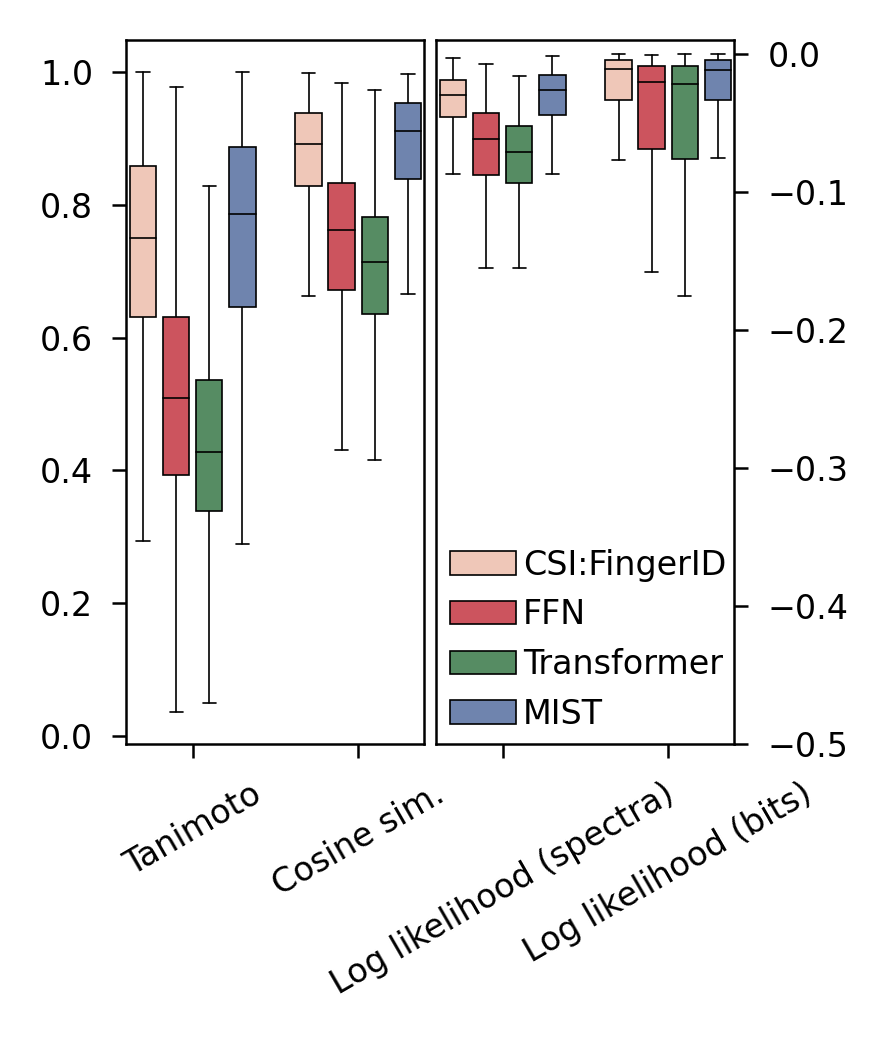

In [21]:
ax_sizes = (1.52, 1.76)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=ax_sizes, dpi=400)
positions = np.arange(len(method_order) * len(metric_order)) 

shifts = np.repeat(np.arange(len(method_order)), 4) 
positions += shifts
centers = [np.mean(i) for i in np.array_split(positions, len(metric_order))]
labels = [metric_rename[i] for i in metric_order]

for ind, (metric, method) in enumerate(
    (list(product(metric_order, method_order)))):
    
    ax = ax1 if "LL" not in metric else ax2

    out_df_temp = out_df.loc[(out_df["metric"] == metric) & (out_df["method"] == method)]
    values = out_df_temp["val"].values
    bplot = ax.boxplot(
        values,
        positions=[positions[ind]],
        widths=0.8,
        patch_artist=True,
        showfliers=False,
        boxprops=dict(linewidth=0.3),
        medianprops=dict(linewidth=0.3),
        whiskerprops=dict(linewidth=0.3),
        capprops=dict(linewidth=0.3),
    )

    color = color_scheme[method]
    for i in bplot["boxes"]:
        i.set_facecolor(color)
    for median in bplot["medians"]:
        median.set_color("black")

ax1.set_xticks(centers[:2])
ax1.set_xticklabels(labels[:2], rotation=30)
ax2.set_xticks(centers[2:])
ax2.set_xticklabels(labels[2:], rotation=30)


legend_handles = [
    Patch(facecolor=color_scheme[method], label=method_rename[method], linewidth=0.3, edgecolor="black")
    for method in method_order
]
legend = ax2.legend(
    handles=legend_handles,
    loc=(0, 0),
    frameon=False,
    facecolor="none",
    fancybox=False,
    handletextpad=0.2,
)

legend.get_frame().set_facecolor("none")
ax2.yaxis.tick_right()
ax2.set_ylim([-0.5, 0.01])

plt.subplots_adjust(
    left=0.1, bottom=0.16, right=0.9, top=0.9, wspace=0.04, hspace=0.4
)
set_size(*ax_sizes, ax1)
fig.savefig(out_folder / f"boxplot_fp_csi.pdf", bbox_inches="tight", dpi=400, transparent=True)


## Build scatter plots 

In [22]:
method_1 = "mist"
method_2 = "sirius"

In [23]:
# Filter to only keep method_1 and method_2
compare_df = out_df[out_df["method"].isin([method_1, method_2])]

In [24]:
# Pivot df to create a comparison that has rows = names and 3 cols: method_1, method_2, and name
row_tbl = compare_df.pivot_table(
    index="name", columns=["metric", "method"], values="val", aggfunc="first"
)

0.052113395785871736 1.0655766256504404
MIST is higher: 3572
CSI:FingerID is higher: 2628
0.2246542370362835 1.0342460564904852
MIST is higher: 3821
CSI:FingerID is higher: 2412
-0.21645825234101215 0.008202389640259239
MIST is higher: 3912
CSI:FingerID is higher: 2321
-0.4339024778154249 0.024741703956240188
MIST is higher: 2659
CSI:FingerID is higher: 2837


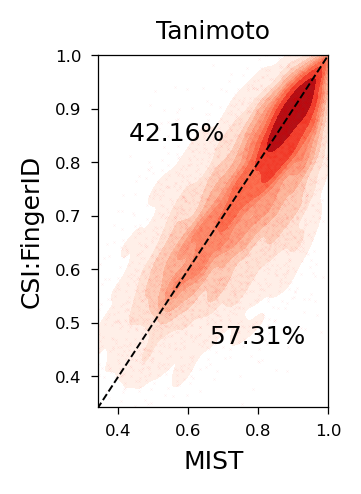

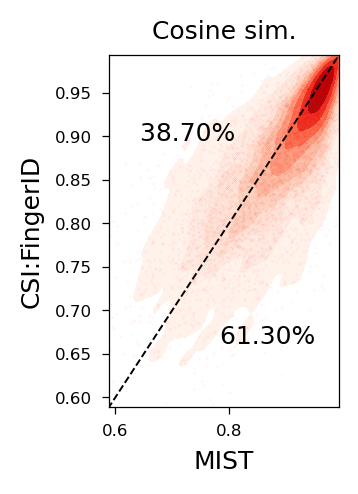

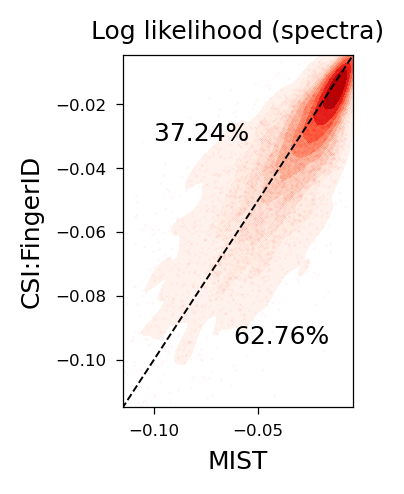

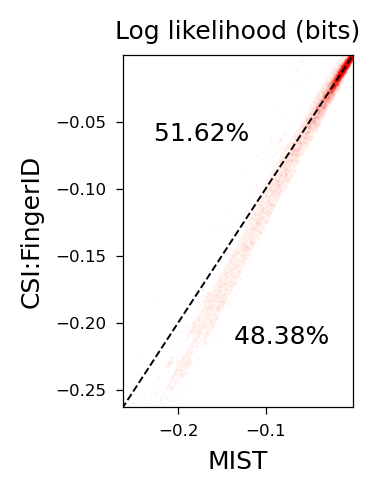

In [25]:
for metric in metric_order:
    # index columns into all where multiindex starts with "cosine"
    row_tbl_sub = row_tbl.loc[:, row_tbl.columns.get_level_values(0).str.startswith(metric)]
    # Filter row_tbl_sub where any row contains NaN
    row_tbl_sub = row_tbl_sub[~row_tbl_sub.isna().any(axis=1)]
    a_res = row_tbl_sub.loc[:, (metric, method_1)].values
    b_res = row_tbl_sub.loc[:, (metric, method_2)].values
    a_name = method_rename[method_1]
    b_name = method_rename[method_2]


    ax_sizes = (1.15, 1.76)
    fig = plt.figure(figsize=(ax_sizes), dpi=200)
    ax = fig.gca()

    sns.kdeplot(
        x=a_res.squeeze(),
        y=b_res.squeeze(),
        shade=True,
        bw_adjust=0.6,
        cmap="Reds",
        ax=ax,
    )  # BW controls curve smoothenss

    # If we want to plot these separately
    a_higher = (a_res - b_res) > 0
    b_higher = (b_res - a_res) > 0
    num_a_higher = a_higher.sum()
    num_b_higher = b_higher.sum()
    c1 = ["red", "red"]
    ax.scatter(
        a_res[a_higher],
        b_res[a_higher],
        marker="x",
        s=0.005,
        alpha=0.1,  # 0.2,
        c=c1[0],
    )
    ax.scatter(
        a_res[b_higher],
        b_res[b_higher],
        marker="x",
        s=0.005,
        alpha=0.1,  # 0.2,
        c=c1[1],
    )
    top_title = f"{metric_rename[metric]}"
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lb = np.min([xlim[0], ylim[0]])
    ub = np.max([xlim[1], ylim[1]])
    print(lb, ub)

    ax.plot(
        np.linspace(-100, 100, 100),
        np.linspace(-100, 100, 100),
        c="black",
        linewidth=0.7,
        linestyle="--",
    )

    # Subset to 95th percentile for zoom
    min_el = [min(i, j) for i, j in zip(a_res.squeeze(), b_res.squeeze())]
    max_el = [max(i, j) for i, j in zip(a_res.squeeze(), b_res.squeeze())]

    lb, ub = np.percentile(min_el, 1), np.percentile(max_el, 99)

    ax.set_xlim([lb, ub])
    ax.set_ylim([lb, ub])

    plt.xlabel(a_name)
    plt.ylabel(b_name)

    print(f"{a_name} is higher: {num_a_higher}")
    print(f"{b_name} is higher: {num_b_higher}")
    left, width = 0.1, 0.35  # .25, 0.25 #0.5
    bottom, height = 0.18, 0.5
    right = left + width
    top = bottom + height
    plt.text(
        left,
        top,
        f"{num_b_higher / (len(a_res)) * 100 : 0.2f}%\n",
        transform=ax.transAxes,
    )
    plt.text(
        right,
        bottom,
        f"{num_a_higher / (len(a_res)) * 100 : 0.2f}%",
        transform=ax.transAxes,
    )
    plt.title(top_title)
    set_size(*ax_sizes, ax)
    plt.savefig(out_folder / f"fp_scatter_{metric}.png", 
                bbox_inches="tight", dpi=400, transparent=True)

## Build barplot on classes

In [26]:
metric="Cosine"

In [27]:
cls_annots = "../results/dataset_analyses/csi2022/smi_to_classes.p"
cls_annots = pickle.load(open(cls_annots, "rb"))

In [28]:
row_tbl_sub = row_tbl.loc[:, row_tbl.columns.get_level_values(0).str.startswith(metric)]
# get rows without NaN in any entries
row_tbl_sub = row_tbl_sub.dropna( axis=0, how='any' )

# Now get chem classes on each row
new_df = []
superclasses = [cls_annots[i]["superclass_results"] for i in row_tbl_sub.index]
for row_ind, superclasses in enumerate(superclasses):
    for superclass in superclasses:
        # Get dataseet row into dict form; use only second column
        row_dict = row_tbl_sub.iloc[row_ind].to_dict()
        row_dict = {k[1]: v for k,v in row_dict.items()}
        row_dict["Superclass"] = superclass
        row_dict['spec'] = row_tbl_sub.index.values[row_ind]
        new_df.append(row_dict)
row_tbl_cls = pd.DataFrame(new_df)

In [29]:
method_1_better  = row_tbl_cls[method_1] > row_tbl_cls[method_2]
method_2_better = row_tbl_cls[method_1] < row_tbl_cls[method_2]
row_tbl_cls["a>b"] = method_1_better
row_tbl_cls["a<b"] = method_2_better
gr_ct = row_tbl_cls.groupby(["Superclass"])[["a<b", "a>b"]].sum()
gr_ct["total"] = gr_ct["a<b"] + gr_ct["a>b"]
gr_ct["diff"] = gr_ct["a>b"] - gr_ct["a<b"]
gr_ct["%"] = (gr_ct["diff"] / gr_ct["total"]) * 100

gr_ct = gr_ct[gr_ct["total"] > 40]
gr_ct_sorted = gr_ct.sort_values(by="%", ascending=False).reset_index()

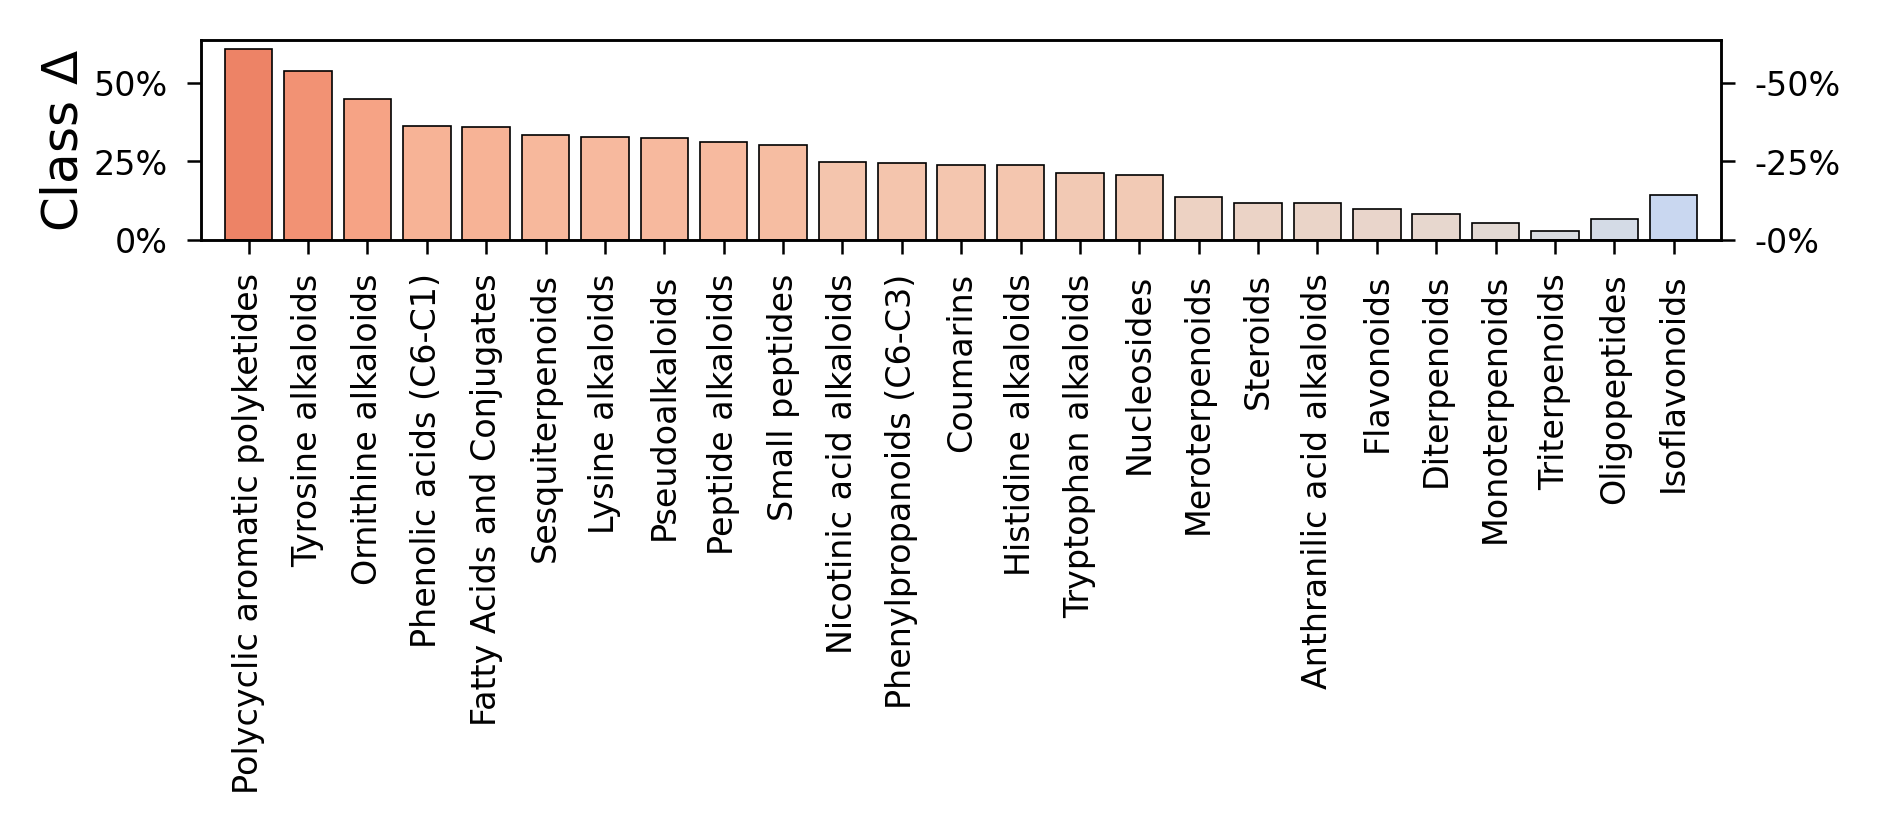

In [30]:
cool_warm = sns.color_palette("coolwarm", as_cmap=True)
ax_sizes = (3.8, 0.5)
fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
x, y = gr_ct_sorted["Superclass"].values, gr_ct_sorted["%"].values
color = [cool_warm(yy / 200 + 0.5) for yy in y]
x = [xx.strip() for xx in x]
out = ax.bar(
    np.arange(len(x)), np.abs(y), color=color, edgecolor="black", linewidth=0.3
)

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation=90)
ax.set_xlim([-0.8, len(x) - 0.2])

fmt = "%.0f%%"
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_ylabel("Class $\Delta$", labelpad=1.0)

neg_ax = ax.twinx()
neg_ax.set_yticks(ax.get_yticks())
neg_ax.set_ylim(ax.get_ylim())

fmt = "-%.0f%%"
yticks = mtick.FormatStrFormatter(fmt)
neg_ax.yaxis.set_major_formatter(yticks)
set_size(*ax_sizes, ax)

# Reset after
neg_ax.set_yticks(ax.get_yticks())
neg_ax.set_ylim(ax.get_ylim())

fig.savefig(out_folder / f"class_delta.pdf", bbox_inches="tight", dpi=400)